In [1]:
%load_ext autoreload
%autoreload 2

# Poisson inverse problem (PInv)

Benchmark on the Poisson inverse problem as proposed in the PINNACLE benchmark paper (https://arxiv.org/pdf/2306.08827) (see Appendix B21: (**PInv**)).

We dig through the PINNACLE code database to retrieve the experimental setting (number of collocation points, number of iterations, ...) as well as the reference values of the solution.

In [2]:
seed = 1

In [3]:
import numpy as np
import jax.numpy as jnp

# from PINNACLE
DEFAULT_NUM_DOMAIN_POINTS = 8192 // 10
DEFAULT_NUM_BOUNDARY_POINTS = 2048 // 10

np.random.seed(seed)
noisy_obs = np.random.normal(loc=0, scale=0.1, size=(2500, 1))

def a_ref_dde(xy):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return 1 / (1 + x**2 + y**2 + (x - 1) ** 2 + (y - 1) ** 2)

def a_ref_jinns(xy):
    x, y = xy[0:1], xy[1:2]
    return 1 / (1 + x**2 + y**2 + (x - 1) ** 2 + (y - 1) ** 2)

def u_ref_dde(xy):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

def u_ref_jinns(xy):
    x, y = xy[0:1], xy[1:2]
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

def f_src_dde(xy):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return (
        2 * jnp.pi**2 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y) * a_ref_dde(xy)
        + 2 * jnp.pi * (
            (2 * x + 1) * jnp.cos(jnp.pi * x) * jnp.sin(jnp.pi * y)
            + (2 * y + 1) * jnp.sin(jnp.pi * x) * jnp.cos(jnp.pi * y)
        ) * a_ref_dde(xy) ** 2
    )

def f_src_jinns(xy):
    x, y = xy[0:1], xy[1:2]
    return (
        2 * jnp.pi**2 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y) * a_ref_jinns(xy)
        + 2 * jnp.pi * (
            (2 * x + 1) * jnp.cos(jnp.pi * x) * jnp.sin(jnp.pi * y)
            + (2 * y + 1) * jnp.sin(jnp.pi * x) * jnp.cos(jnp.pi * y)
        ) * a_ref_jinns(xy) ** 2
    )
    
ref_sol_dde = lambda xy: jnp.concatenate((u_ref_dde(xy), a_ref_dde(xy)), axis=1)
ref_sol_jinns = lambda xy: jnp.concatenate((u_ref_jinns(xy), a_ref_jinns(xy)), axis=1)


bc_x = np.linspace(0, 1, 50)
bc_y = np.linspace(0, 1, 50)
bc_x, bc_y = np.meshgrid(bc_x, bc_y)
bc_xy = np.stack((bc_x.reshape(-1), bc_y.reshape(-1))).T

**Summary:**
- [DeepXDE](#DeepXDE)
- [jinns](#jinns)
- [PINA](#PINA)
- [Comparisons](#Comparisons)

## DeepXDE


We use the JAX backend.

Compiling model...
'compile' took 0.041131 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.82e+01, 2.15e-01, 4.40e-01]    [1.82e+01, 2.15e-01, 4.40e-01]    []  
1000      [1.03e-03, 2.78e-05, 3.77e-02]    [1.03e-03, 2.78e-05, 3.77e-02]    []  
2000      [5.09e-04, 4.95e-05, 3.73e-02]    [5.09e-04, 4.95e-05, 3.73e-02]    []  
3000      [2.08e-02, 8.20e-07, 3.77e-02]    [2.08e-02, 8.20e-07, 3.77e-02]    []  
4000      [7.67e-04, 3.32e-07, 3.69e-02]    [7.67e-04, 3.32e-07, 3.69e-02]    []  
5000      [3.18e-04, 1.47e-05, 3.68e-02]    [3.18e-04, 1.47e-05, 3.68e-02]    []  
6000      [2.54e-04, 3.14e-06, 3.66e-02]    [2.54e-04, 3.14e-06, 3.66e-02]    []  
7000      [3.35e-04, 1.43e-07, 3.65e-02]    [3.35e-04, 1.43e-07, 3.65e-02]    []  
8000      [2.35e-04, 1.38e-07, 3.63e-02]    [2.35e-04, 1.38e-07, 3.63e-02]    []  
9000      [2.30e-04, 1.42e-07, 3.62e-02]    [2.30e-04, 1.42e-07, 3.62e-02]    []  
10000     [5.00

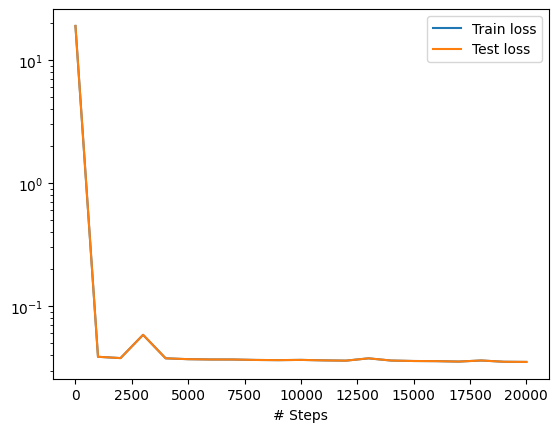

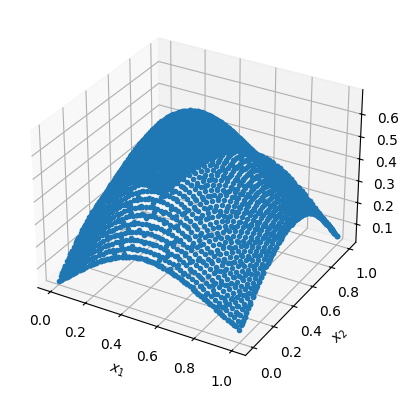

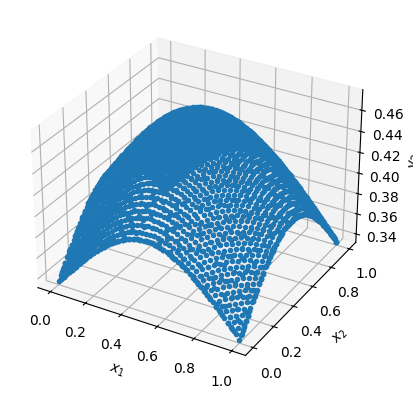

In [6]:
import os
os.environ["DDE_BACKEND"]="jax"
import deepxde as dde

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(seed)

# PDE for JAX
def pde(x, ua):
    ua_val, ua_fn = ua
    u, a = ua_val[:, 0:1], ua_val[:, 1:2]
    u_x, u_x_fn = dde.grad.jacobian(ua, x, i=0, j=0)
    u_y, u_y_fn = dde.grad.jacobian(ua, x, i=0, j=1)
    d_au, _ = dde.grad.jacobian((a * u_x, u_x_fn), x, i=0, j=0) 
    d_au += dde.grad.jacobian((a * u_y, u_y_fn), x, i=0, j=1)[0]
    return d_au + f_src_dde(x)

# PDE for pytorch
# def pde(x, ua):
#     u, a = ua[:, 0:1], ua[:, 1:2]
#     u_x = dde.grad.jacobian(u, x, i=0, j=0)
#     u_y = dde.grad.jacobian(u, x, i=0, j=1)
#     d_au = dde.grad.jacobian(a * u_x, x, i=0, j=0) + dde.grad.jacobian(a * u_y, x, i=0, j=1)
#     return d_au + self.f_src(x)

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])

bc_a = dde.icbc.DirichletBC(geom, a_ref_dde, (lambda _, on_boundary: on_boundary), 1)

data_loss = dde.icbc.PointSetBC(bc_xy, u_ref_dde(bc_xy) + noisy_obs, 0)

data = dde.data.PDE(
    geom,
    pde,
    [bc_a, data_loss],
    num_domain=DEFAULT_NUM_DOMAIN_POINTS,
    num_boundary=DEFAULT_NUM_BOUNDARY_POINTS,
    # train_distribution="uniform" # this is the default
    # num_test=None # this is the Default, we perform a evaluation callback on the same dataset as the training (see the test column in the training log)
)
net = dde.nn.PFNN([2] + [[50] * 2] * 5 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## jinns

In [5]:
import jax
import equinox as eqx
import jinns
import jax.numpy as jnp
from jax import grad, vmap, random
import optax
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(seed)

In [6]:
eqx_list = (
    (eqx.nn.Linear, 2, 50), # shared inputs are considered
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 1) # 1 for u in one case and 1 for a in another case
)
key, subkey = random.split(key)
ua_pinn, init_ua_nn_params = jinns.utils.create_PPINN(subkey, (eqx_list,) * 2, "nonstatio_PDE", 2, slice_solution=jnp.s_[:1])

In [7]:
n = DEFAULT_NUM_DOMAIN_POINTS
nb = DEFAULT_NUM_BOUNDARY_POINTS
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
method = "grid" # equals "uniform" in deepXDE, while "uniform" in jinns equals "pseudo" in deepXDE

train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    method=method,
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/data/_DataGenerators.py:434: UserWarning: Grid sampling is requested in dimension 2 with a non perfect square dataset size (self.n = 819). Modifying self.n to self.n = 841.
  warnings.warn(


In [8]:
# Init parameters for NN and equation
init_params_pinn = jinns.parameters.Params(
    nn_params=init_ua_nn_params,
    eq_params={}
)

In [9]:
from jinns.loss import PDEStatio

class PoissonInv(PDEStatio):
    def equation(self, x, ua, params):
        u_pinn = lambda x, params: jnp.squeeze(ua(x, params)[ua.slice_solution])
        a_times_jac_u = lambda x, params: ua(x, params)[1:2] * jax.jacrev(u_pinn, 0)(x, params)
        return jinns.loss.divergence_rev(x, a_times_jac_u, params, eq_type="statio_PDE")[None] + f_src_jinns(x)

In [10]:
p_loss = PoissonInv()

loss_weights = jinns.loss.LossWeightsPDEStatio(
    dyn_loss=1, observations=1, boundary_loss=1
)

In [11]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    obs_batch_size=None,
    observed_pinn_in=bc_xy,
    observed_values=jax.vmap(u_ref_jinns)(bc_xy) + noisy_obs
)

In [12]:
loss_pinn = jinns.loss.LossPDEStatio(
    u=ua_pinn,
    loss_weights=loss_weights,
    dynamic_loss=p_loss,
    omega_boundary_fun=a_ref_jinns,
    omega_boundary_condition="dirichlet",
    omega_boundary_dim=jnp.s_[1:2],
    params=init_params_pinn,
    obs_slice=jnp.s_[0:1]
)

In [13]:
# Training loop in Jinns
params_pinn = init_params_pinn
tx = optax.adam(learning_rate=1e-3)
n_iter = 20000

In [14]:
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
    verbose=True,
    obs_data=obs_data
)


Compilation took
 6.88190484046936 

[train] Iteration 0: loss value = 21.017351150512695
[train] Iteration 1000: loss value = 0.021489445120096207
[train] Iteration 2000: loss value = 0.01730371080338955
[train] Iteration 3000: loss value = 0.01579119637608528
[train] Iteration 4000: loss value = 0.03893928602337837
[train] Iteration 5000: loss value = 0.017437947914004326
[train] Iteration 6000: loss value = 0.014113073237240314
[train] Iteration 7000: loss value = 0.013756650499999523
[train] Iteration 8000: loss value = 0.02816968970000744
[train] Iteration 9000: loss value = 0.017333094030618668
[train] Iteration 10000: loss value = 0.012891816906630993
[train] Iteration 11000: loss value = 0.012746497988700867
[train] Iteration 12000: loss value = 0.012889474630355835
[train] Iteration 13000: loss value = 0.012732482515275478
[train] Iteration 14000: loss value = 0.012181026861071587
[train] Iteration 15000: loss value = 0.012394092977046967
[train] Iteration 16000: loss value =

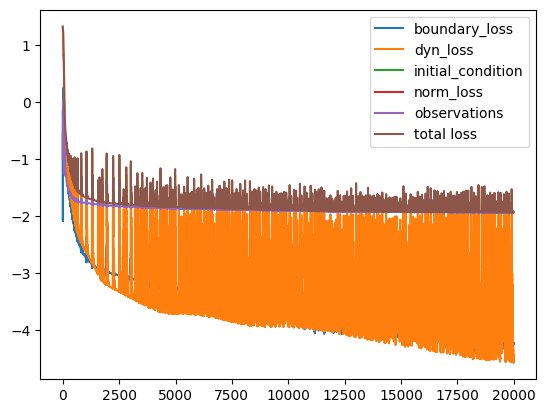

In [15]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

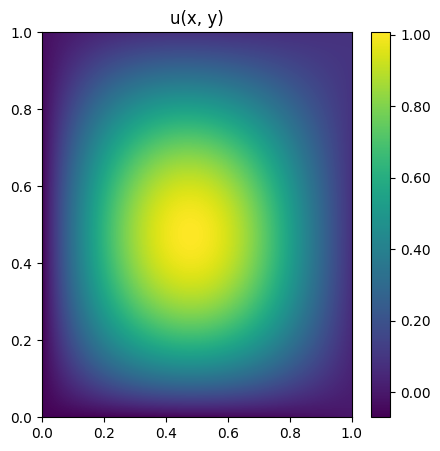

In [16]:
u_est = lambda x: ua_pinn(x, params_pinn)[0]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(u_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="u(x, y)")

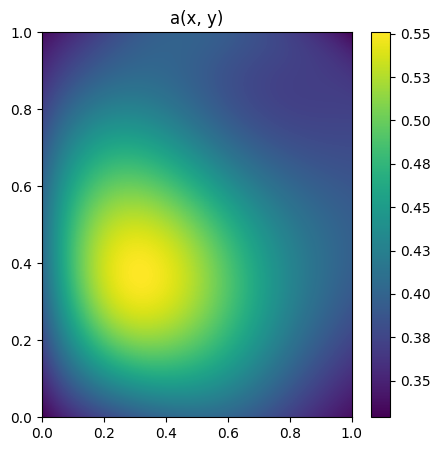

In [17]:
a_est = lambda x: ua_pinn(x, params_pinn)[1]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(a_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="a(x, y)")

## PINA

In [4]:
from pytorch_lightning import seed_everything

# setting the seed for reproducibility
seed_everything(seed, workers=True)

Seed set to 1


1

In [5]:
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import torch
from pytorch_lightning.callbacks import Callback
from pina.problem import SpatialProblem, InverseProblem
from pina.operators import grad, div
from pina.model import FeedForward
from pina.equation import Equation, FixedValue
from pina import Condition, Trainer, LabelTensor
from pina.solvers import PINN
from pina.geometry import CartesianDomain

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
### Define ranges of variables
x_min = 0
x_max = 1
y_min = 0
y_max = 1

def u_ref_pina(xy):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

def a_ref_pina(input_):
    x = input_.extract(['x'])
    y = input_.extract(['y'])
    return 1 / (1 + x**2 + y**2 + (x - 1) ** 2 + (y - 1) ** 2)

def f_src_pina(input_, output_):
    x = input_.extract(['x'])
    y = input_.extract(['y'])
    return (
        2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * a_ref_dde(input_)
        + 2 * torch.pi * (
            (2 * x + 1) * torch.cos(torch.pi * x) * torch.sin(torch.pi * y)
            + (2 * y + 1) * torch.sin(torch.pi * x) * torch.cos(torch.pi * y)
        ) * a_ref_dde(input_) ** 2
    )


input_points_pina = LabelTensor(torch.from_numpy(bc_xy).float(), labels=['x', 'y'])
output_points_pina = LabelTensor(u_ref_pina(torch.from_numpy(bc_xy).float().to(device)) + torch.from_numpy(noisy_obs).float().to(device), labels=['u'])


class PInv(SpatialProblem):

    output_variables = ['u', 'a']

    spatial_domain = CartesianDomain({'x': [x_min, x_max], 'y': [y_min, y_max]})

            
    def laplace_equation(input_, output_):

        du_dx = grad(output_, input_, components='u', d=['x', 'y'])

        a_times_du_dx = LabelTensor(
            output_.extract(['a']) * du_dx,
            labels=['ua_x', 'ua_y']
        )

        return div(a_times_du_dx, input_, components=['ua_x', 'ua_y'], d=['x', 'y']) + f_src_pina(input_, output_)

    def boundary_condition(input_, output_):
        a_expected = a_ref_pina(input_)
        return output_.extract(['a']) - a_expected

    def data_equation(input_, output_):
        u_expected = output_points_pina
        return output_.extract(['u']) - u_expected

    # define the conditions for the loss (boundary conditions, equation, data)
    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': [x_min, x_max],
            'y':  y_max}),
            equation=Equation(boundary_condition)),
        'gamma2': Condition(location=CartesianDomain({'x': [x_min, x_max], 'y': y_min
            }),
            equation=Equation(boundary_condition)),
        'gamma3': Condition(location=CartesianDomain({'x':  x_max, 'y': [y_min, y_max]
            }),
            equation=Equation(boundary_condition)),
        'gamma4': Condition(location=CartesianDomain({'x': x_min, 'y': [y_min, y_max]
            }),
            equation=Equation(boundary_condition)),
        'D': Condition(location=CartesianDomain({'x': [x_min, x_max], 'y': [y_min, y_max]
            }),
        equation=Equation(laplace_equation)),
        'data': Condition(
            input_points=input_points_pina,
            equation=Equation(data_equation)
        )
    }

problem = PInv()

In [8]:
from math import sqrt
problem.discretise_domain(
    n=int(sqrt(DEFAULT_NUM_DOMAIN_POINTS)), # NOTE the sqrt
    mode='grid',
    variables=['x', 'y'],
    locations='D'
)
problem.discretise_domain(
    n=DEFAULT_NUM_BOUNDARY_POINTS // 4, # divide by 4 since NUM_BOUNDARY is the total
    mode='grid',
    variables=['x', 'y'],
    locations=['gamma1', 'gamma2', 'gamma3', 'gamma4']
)
print('Input points:', problem.input_pts['D'].shape)
print('Input points:', problem.input_pts['gamma2'].shape)
print('Input points:', problem.input_pts['gamma1'].shape)

Input points: torch.Size([784, 2])
Input points: torch.Size([51, 2])
Input points: torch.Size([51, 2])


In [9]:
from pina import Trainer
from pina.solvers import PINN
from pina.model import MultiFeedForward
from pina.callbacks import MetricTracker, PINAProgressBar
from pytorch_lightning.callbacks import Timer

pbar = PINAProgressBar(metrics=['mean'], refresh_rate=1)

class PFNN(MultiFeedForward):

    def __init__(self, dff_dict):
        super().__init__(dff_dict)

    def forward(self, x):
        u_out = self.u(x)
        u_out.labels = ['u']
        a_out = self.a(x)
        a_out.labels = ['a']

        return LabelTensor(
            torch.hstack((u_out.extract('u'), a_out.extract('a'))),
            ['u', 'a']
        )

# create model
model_ = PFNN(
    {
        'u': {
            'input_dimensions': 2,
            'output_dimensions': 1,
            'layers': [50, 50, 50, 50, 50],
            'func': torch.nn.Tanh,
        },
        'a': {
            'input_dimensions': 2,
            'output_dimensions': 1,
            'layers': [50, 50, 50, 50, 50],
            'func': torch.nn.Tanh,
        },
    }
)

# create the PINN object
pinn = PINN(
    problem,
    model_,
    optimizer=torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3}
)

# create the trainer
trainer = Trainer(
    solver=pinn,
    max_epochs=20000,
    callbacks=[MetricTracker(), pbar, Timer()],
    accelerator='gpu',
    enable_model_summary=False,
    log_every_n_steps=1000,
    val_check_interval=1000,
    check_val_every_n_epoch=None,
    enable_checkpointing=False
) 

# train
trainer.train()

print(f'Total training time {trainer.callbacks[-1].time_elapsed("train"):.5f} s')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-12-04 16:25:38.558719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733325938.573619  115899 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733325938.578127  115899 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/hugo/anaconda3/envs/pinn_gpu/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=1000). Set a lower value for log_every_n_steps if you want to see logs for t

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20000` reached.


Total training time 1509.68516 s


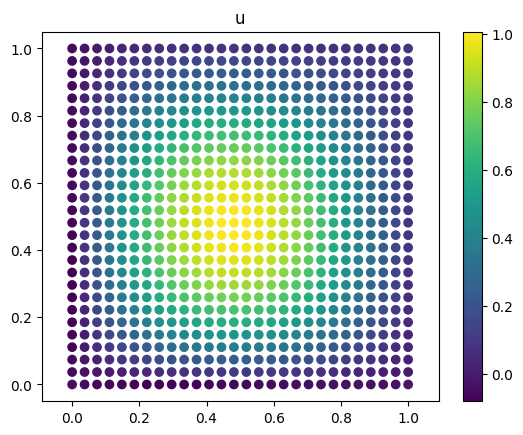

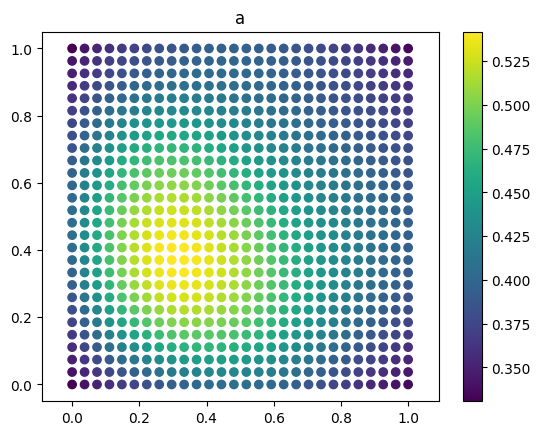

In [10]:
points = problem.input_pts['D'].extract(['x', 'y'])
plt.scatter(points[:, 0], points[:, 1], c=pinn(problem.input_pts['D'])[:, 0].detach().cpu().numpy(),)
plt.axis('equal')
plt.title('u')
plt.colorbar()
plt.show()

plt.scatter(points[:, 0], points[:, 1], c=pinn(problem.input_pts['D'])[:, 1].detach().cpu().numpy(),)
plt.axis('equal')
plt.title('a')
plt.colorbar()
plt.show()

## Comparisons

We have an analytical reference solution so we will evaluate on sampled points from the geometry (https://github.com/i207M/PINNacle/blob/main/src/utils/callbacks.py#L135)

In [11]:
import sys
sys.path.append('../')
import deepxde as dde
from PINNacle_utils import compute_relative_errors
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])

test_x = geom.random_points(2500)
test_y = ref_sol_dde(test_x)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [19]:
compute_relative_errors(test_y, model.predict(test_x))

l1re=0.16855319, l2re=0.26172224


In [20]:
pred = jax.vmap(ua_pinn, (0, None))(test_x, params_pinn)
compute_relative_errors(test_y, pred)

l1re=0.07009917, l2re=0.087523215


In [12]:
compute_relative_errors(np.asarray(test_y), pinn(LabelTensor(np.asarray(test_x), labels=['x', 'y'])).detach().cpu().numpy())

l1re=0.066652544, l2re=0.083397545
